In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
def parse_file(fp):
    d = np.load(fp, allow_pickle=True).item()
    return d

In [11]:
def sigma(sig_ln, F0, alpha):
    ''' Compute sigma'''
    return sig_ln * F0**(1-alpha)

def X(F, alpha, sig):
    ''' X transform variable '''
    return F**(2 * (1-alpha)) / (sig**2 * (1-alpha)**2)

def F_Xinv(X, alpha, sig):
    ''' F from X'''
    return (X * (sig**2 * (1-alpha)**2)) ** (1/(2*(1-alpha)))

def delta(alpha):
    ''' delta from alpha'''
    return (1 - 2*alpha) / (1 - alpha)

def em_CEV(T, dt, F0, alpha, sig):
    ''' Euler scheme simulation '''
    
    # set up Brownian motion and t
    t = np.arange(dt, T + dt, dt)
    N = len(t)
    dW=np.sqrt(dt)*np.random.randn(N)
    
    # init variables
    X0 = X(F0, alpha, sig)
    d = delta(alpha)
    X_emC, X_em = X0, []
    hit_zero = False
    
    # For all timesteps
    for j in range(N):
        # euler (X + XdX)=(X + X * (d*dt + 2X^(1/2)dW))
        dX = d*dt + 2*np.sqrt(X_emC)*dW[j]
        X_emC += dX
        
        # if <= 0, presumed it hit boundary of 0
        if X_emC <= 0:
            # fill with 0's since it is absorbed
            X_em += [0 for i in range(N - len(X_em))]
            hit_zero = True
            break
        X_em.append(X_emC)
    
    return X_em, hit_zero



def mil_CEV(T, dt, F0, alpha, sig):
    ''' Milstein scheme simulation '''
    
    # set up Brownian motion and t
    t = np.arange(dt, T + dt, dt)
    N = len(t)
    dW=np.sqrt(dt)*np.random.randn(N)
    
    # init variables
    X0 = X(F0, alpha, sig)
    d = delta(alpha)
    X_milC, X_mil = X0, []
    hit_zero = False
    
    # For all timesteps
    for j in range(N):
        # Milstein 
        dX = d*dt + 2*np.sqrt(X_milC)*dW[j] + 2*(dW[j]**2 - dt)
        X_milC += dX
        
        # if <= 0, presumed it hit boundary of 0
        if X_milC <= 0:
            # fill with 0's since it is absorbed
            X_mil += [0 for i in range(N - len(X_mil))]
            hit_zero = True
            break
        X_mil.append(X_milC)
    
    return X_mil, hit_zero
    
    

In [9]:
import math
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    """
    Calculate the price of a European call option using the Black-Scholes formula.

    Parameters:
    S (float): Current stock price
    K (float): Strike price of the option
    T (float): Time to expiration (in years)
    r (float): Risk-free interest rate (annual)
    sigma (float): Volatility of the underlying asset (annual)

    Returns:
    call_price (float): Price of the European call option
    """
    d1 = (np.log(S / K) + (r + (sigma**2) / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    return call_price

In [19]:
def sigma(sig_ln, F0, alpha):
    ''' Compute sigma'''
    return sig_ln * F0**(1-alpha)

def analytical_C(F,K,T, alpha, sig_ln):
    sig = sigma(sig_ln, F, alpha)
    K_tilde = X(K,alpha, sig)
    X0 = X(F,alpha, sig)
    C = F * (1 - stats.ncx2.cdf(x = K_tilde/T, df = 4 - delta(alpha), nc = X0/T)) - K * stats.ncx2.cdf(x = X0/T, df = 2 - delta(alpha),nc = K_tilde/T)
    
    return C

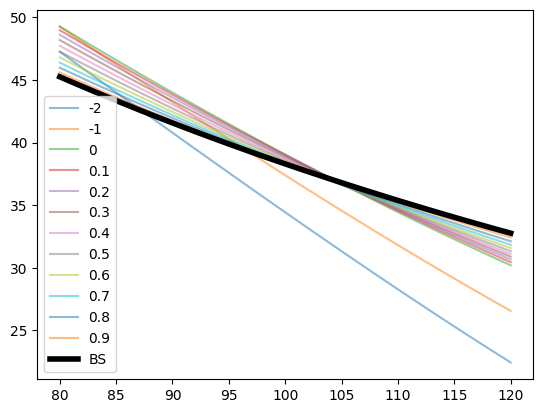

In [134]:
alphas = [-2, -1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
Ks = np.linspace(80, 120, 41); atmK = 100
b = black_scholes_call(100, Ks, 4, 0, .5)
l = []
for a in alphas:
    y = analytical_C(100, Ks, 4, a, .5)
    plt.plot(Ks, y, alpha = .5, label=str(a))
plt.plot(Ks, b, 'k', lw = 4, label='BS')
plt.legend() 

In [64]:
b = black_scholes_call(100, Ks, 4, 0, .5)
b

array([45.24480186, 44.85624362, 44.47240889, 44.09322318, 43.71861339,
       43.34850775, 42.98283585, 42.62152857, 42.26451808, 41.9117378 ,
       41.56312236, 41.21860765, 40.87813068, 40.54162968, 40.20904399,
       39.88031406, 39.55538144, 39.23418876, 38.9166797 , 38.60279896,
       38.29249225, 37.98570628, 37.68238871, 37.38248816, 37.08595418,
       36.79273723, 36.50278865, 36.21606067, 35.93250638, 35.65207968,
       35.37473532, 35.10042884, 34.82911658, 34.56075564, 34.29530388,
       34.03271992, 33.77296307, 33.51599338, 33.26177159, 33.01025912,
       32.76141806])

In [178]:
alphas = [-2, -1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
Ks = np.linspace(90, 110, 3).astype(int); atmK = 100

In [179]:
import pandas as pd

In [180]:
def get_df(Ks, alphas):
    df = []
    for K in Ks:
        for a in alphas:
            d = parse_file(f"data/{K}_{a}.npy") 
            del d['ems']
            del d['F_T']
            df.append(d)
    return pd.DataFrame(df)

In [181]:
def get_exp_std(df, K):
    df = df[df['K'] == K]
    return df[['K', 'alpha', 'E[C]', 'STE[C]', 'A[C]', 'E[P]', 'STE[P]', 'A[P]']]


In [199]:
def plot_comparison(df, alphas):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].scatter(np.array(alphas).astype(str), df['A[C]'], s=20, c = 'r', marker='^', label='Analytical C' )
    ax[0].scatter(np.array(alphas).astype(str), df['E[C]'], s=10, c = 'b', label='Simulated E[C]')
    ax[0].legend()
    
    ax[1].scatter(np.array(alphas).astype(str), df['A[P]'], s=20, c = 'r', marker='^', label='Analytical P' )
    ax[1].scatter(np.array(alphas).astype(str), df['E[P]'], s=10, c = 'b', label='Simulated E[P]')
    ax[1].legend()
    
    
    ax[0].set_title('Calls')
    ax[1].set_title('Puts')
    ax[0].set_xlabel('alpha')
    ax[0].set_ylabel('$')
    ax[1].set_xlabel('alpha')
    ax[1].set_ylabel('$')   
    plt.show()

In [192]:
df = get_df(Ks, alphas)

In [193]:
df.head()

,K,alpha,dt,F,T,sig_ln,sig,E[C],STE[C],E[P],STE[P],A[C],A[P],Sim Absorption Ratio,Analytical Absorption Ratio
0,90,-2.0,0.001,100,4,0.5,500000.000000,36.187308,0.037903,39.019074,0.044496,40.780077,30.780077,0.428172,0.339364
1,90,-1.0,0.001,100,4,0.5,5000.000000,41.510101,0.046382,36.543608,0.043737,43.223240,33.223240,0.395092,0.359843
2,90,0.0,0.001,100,4,0.5,50.000000,43.969779,0.062019,34.138504,0.040895,43.988098,33.988098,0.317367,0.317311
3,90,0.1,0.001,100,4,0.5,31.547867,43.865170,0.064291,33.865168,0.040209,43.814905,33.814905,0.297309,0.298567
4,90,0.2,0.001,100,4,0.5,19.905359,43.523201,0.066777,33.541395,0.039355,43.587152,33.587152,0.270677,0.273206


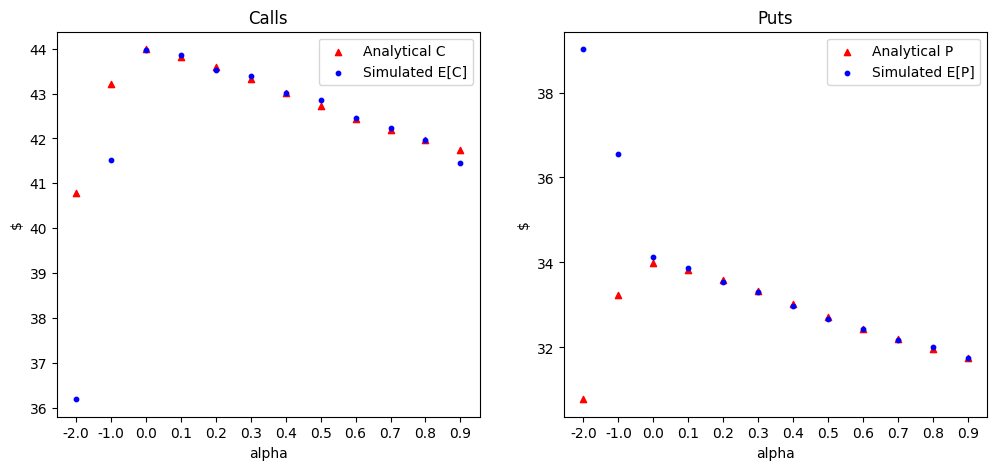

,K,alpha,E[C],STE[C],A[C],E[P],STE[P],A[P]
0,90,-2.0,36.187308,0.037903,40.780077,39.019074,0.044496,30.780077
1,90,-1.0,41.510101,0.046382,43.223240,36.543608,0.043737,33.223240
2,90,0.0,43.969779,0.062019,43.988098,34.138504,0.040895,33.988098
3,90,0.1,43.865170,0.064291,43.814905,33.865168,0.040209,33.814905
4,90,0.2,43.523201,0.066777,43.587152,33.541395,0.039355,33.587152
5,90,0.3,43.398897,0.069841,43.315874,33.302086,0.038366,33.315874
6,90,0.4,43.016304,0.073029,43.020129,32.976107,0.037213,33.020129
7,90,0.5,42.864001,0.077001,42.723105,32.678325,0.035879,32.723105
8,90,0.6,42.453352,0.081451,42.443138,32.437105,0.034509,32.443138
9,90,0.7,42.232714,0.086937,42.187546,32.173736,0.033134,32.187546


In [201]:
df90 = get_exp_std(df, 90)

plot_comparison(df90, alphas)
df90

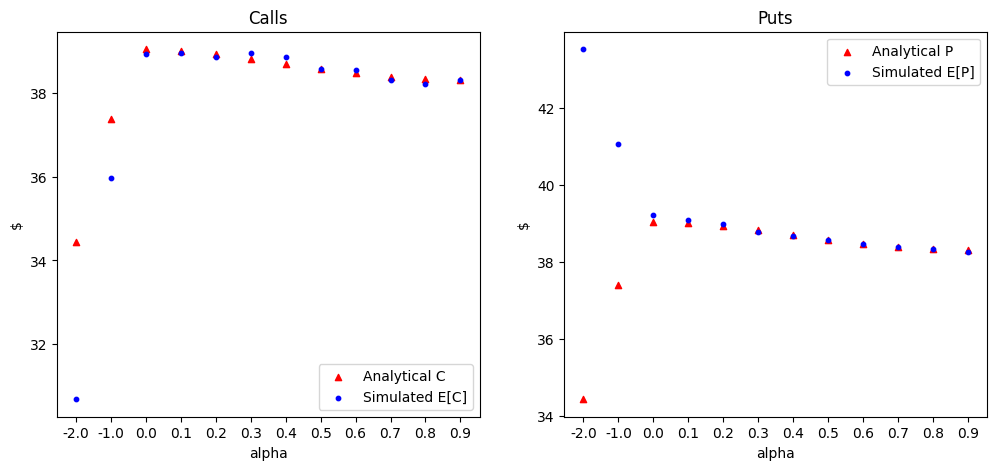

,K,alpha,E[C],STE[C],A[C],E[P],STE[P],A[P]
12,100,-2.0,30.685021,0.033738,34.429275,43.531046,0.049341,34.429275
13,100,-1.0,35.957393,0.042491,37.387498,41.059965,0.048409,37.387498
14,100,0.0,38.923453,0.058344,39.045158,39.217987,0.045086,39.045158
15,100,0.1,38.956205,0.060843,39.008871,39.099992,0.044335,39.008871
16,100,0.2,38.871043,0.063453,38.930696,38.989623,0.043460,38.930696
17,100,0.3,38.950160,0.066696,38.820970,38.769087,0.042380,38.820970
18,100,0.4,38.853272,0.070116,38.696191,38.667578,0.041161,38.696191
19,100,0.5,38.584081,0.073691,38.575276,38.579816,0.039789,38.575276
20,100,0.6,38.540105,0.078516,38.472361,38.462754,0.038365,38.472361
21,100,0.7,38.313215,0.083919,38.392789,38.376081,0.036938,38.392789


In [203]:
df100 = get_exp_std(df, 100)
plot_comparison(df100, alphas)
df100

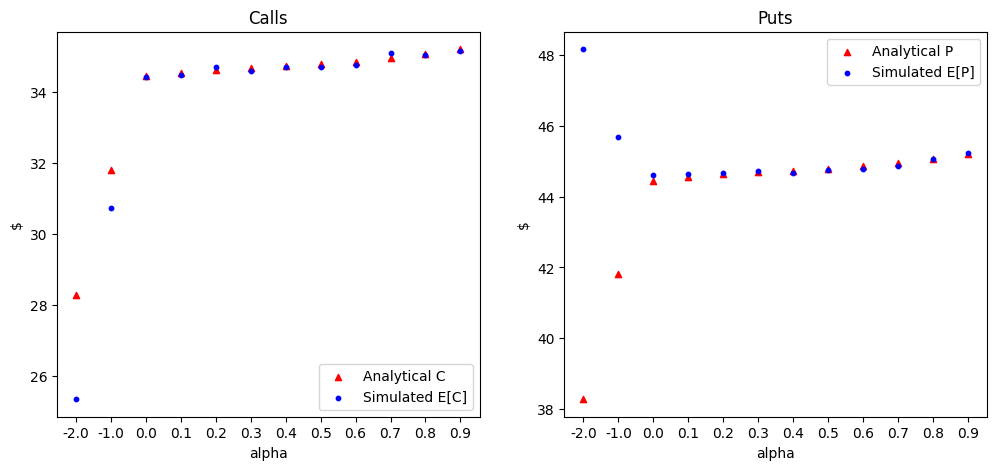

,K,alpha,E[C],STE[C],A[C],E[P],STE[P],A[P]
24,110,-2.0,25.355508,0.029643,28.280139,48.162711,0.054088,38.280139
25,110,-1.0,30.739171,0.038717,31.810867,45.695260,0.052928,41.810867
26,110,0.0,34.419749,0.054955,34.446702,44.600330,0.049167,44.446702
27,110,0.1,34.496569,0.057372,34.553868,44.636357,0.048358,44.553868
28,110,0.2,34.702677,0.060191,34.630008,44.657599,0.047418,44.630008
29,110,0.3,34.603836,0.062967,34.684381,44.724895,0.046269,44.684381
30,110,0.4,34.699618,0.066512,34.730942,44.669125,0.044991,44.730942
31,110,0.5,34.707498,0.070373,34.784979,44.746047,0.043567,44.784979
32,110,0.6,34.772220,0.075202,34.857457,44.783257,0.042088,44.857457
33,110,0.7,35.098378,0.081359,34.952468,44.870044,0.040607,44.952468


In [204]:
df110 = get_exp_std(df, 110)
plot_comparison(df110, alphas)
df110

In [205]:
def plot_sims(K, a, skip = 5):
    d = parse_file(f"data/{K}_{a}.npy") 
    t = np.arange(d['dt'], d['T'] + d['dt'], d['dt'])
    for e in d['ems'][::skip]:
        plt.plot(t, e, alpha = .5)
    plt.xlabel('t')
    plt.ylabel('X')

In [206]:
def plot_absorbed(df):
    plt.scatter(np.array(alphas).astype(str), df['Analytical Absorption Ratio'],s = 5, marker='^', c = 'r', label='Analytical Absorption Ratio')
    plt.scatter(np.array(alphas).astype(str), df['Sim Absorption Ratio'],s = 2.5, c='b', label='Simulated Absorbtion Ratio')   
    plt.xlabel('alpha')
    plt.title('Absorption Ratio')
    plt.ylabel('Gamma(-v;X0/T)')

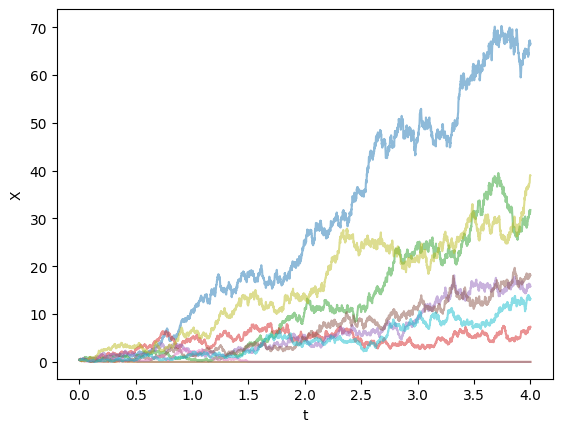

In [212]:
plot_sims(100, -2, skip = 100)

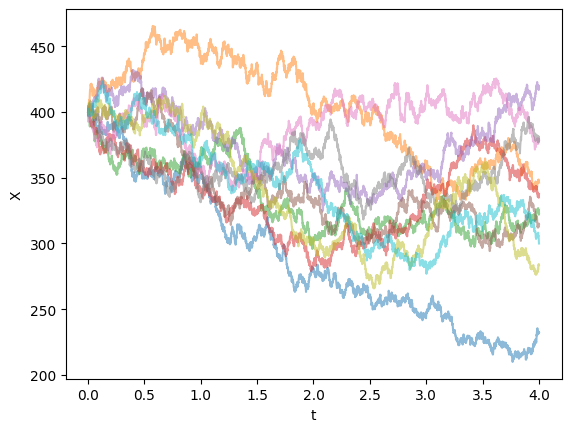

In [220]:
plot_sims(110,0.9, skip = 100)